### Imports

In [2]:
# data
# from sklearn.datasets import fetch_mldata # this doesn't work on the new version of sklearn
from sklearn.datasets import fetch_openml
import numpy as np
import random

# models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# model validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

# visualisation
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Getting the data 
# mnist = fetch_mldata('MNIST original')

mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)  # a new way of getting the mnist dataset


In [4]:
# ordering the dataset as explained in here: https://github.com/ageron/handson-ml/issues/301#issuecomment-448853256

def sort_by_target(mnist):
    reorder_train = np.array(
        sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(
        sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

# fetch_openml() returns targets as strings
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)  # fetch_openml() returns an unsorted dataset

In [5]:
# Getting dataset info
# print(mnist)

# Split into data and labels
X, y = mnist['data'], mnist['target']

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


<function matplotlib.pyplot.show(close=None, block=None)>

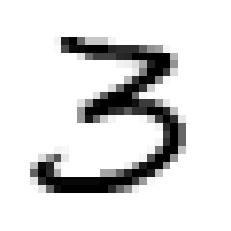

In [6]:
# Showing a sample of the dataset
%matplotlib inline

random_int = random.randint(0, X.shape[0])

random_number = X[random_int].reshape(28, 28)
plt.imshow(random_number, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show

### Data prep

In [7]:
# shuffling the data 

shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]

In [8]:
# 6000/1000 train test split

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Developing as 5 identifier

Using a stochastic gradient descent model, we're going to build a model that will try to determine if an image is representing a number five.

In [9]:
# Creating a boolean mask for 5 and non-5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# Training the SGD Classification model

sgd_class = SGDClassifier(random_state=42)
sgd_class.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

It's some other number...


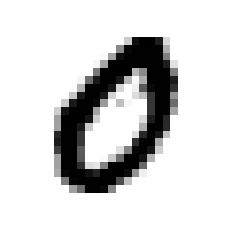

In [11]:
rand = random.randint(0, 10000)
X_example = X_test[rand]
y_example = y_test[rand]

%matplotlib inline

plt.imshow(X_example.reshape(28,28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')

if sgd_class.predict([X_example])[0]:
    print('It\'s a five!')
else:
    print('It\'s some other number...')

### Measuring the accuracy of the model

In [12]:
# Using cross-validation

# The outcome of this validation (accuracy) is usually 95% or better
# That is mostly because 90% of the data is not 5
# Ther model is training on skewed data, therefore,
# accuracy is not the best measure for validation of the model

cross_val_score(sgd_class, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9694, 0.9676, 0.9583])

In [13]:
# Getting the set of predictions from the model for analysis

y_train_pred = cross_val_predict(sgd_class, X_train, y_train_5) # How exactly does it make predictions

In [14]:
len(y_train_pred)

60000

In [15]:
# Generating the confusion matrix for the model's prediction

conf_mat = confusion_matrix(y_train_5, y_train_pred)
conf_mat

array([[53360,  1253],
       [ 1129,  4258]])

In [17]:
# Calculating precision and recall

# Precision - Out of all classified as 5's, those that actually were 5's
p = conf_mat[1][1] / (conf_mat[0][1] + conf_mat[1][1])

# Recall - Out of all 5's, those that were correctly classified
r = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

Precision: 77.26%
Recall: 79.04%


In [18]:
# Calculatin precision and recall with scikit learn

p = precision_score(y_train_5, y_train_pred)
r = recall_score(y_train_5, y_train_pred)

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

# We can also calculate the F1 score
# That is, a harmonic mean of precision and recall.

# This is a measure that get's higher the more similar precision and recall values are
f1 = f1_score(y_train_5, y_train_pred)

print(f'F1 score: {round(f1*100,2)}%')

Precision: 77.26%
Recall: 79.04%
F1 score: 78.14%


In [25]:
# In order to understand and modify the threshold value of the SGD classifier
# we can call it's `decision_function()` that will tell us the score
# of how likely the image represents a 5.
# Than we can make the decision ourselves and see how different measures change.

y_scores = sgd_class.decision_function([X_example])
print('Example y score: ' + str(y_scores))

# SGD classifier uses a threshold value of 0 by defaut
threshold = 0
print(y_scores > threshold)

# We can now change the threshold
threshold = 200000
print(y_scores < threshold)


Example y score: [-7368.80226362]
[False]
[ True]


In [26]:
# The score for each prediction can be calculated by the cross_valid_predict()

y_scores = cross_val_predict(sgd_class, X_train, y_train_5, cv=3, method='decision_function')

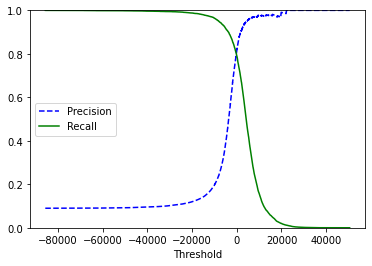

In [40]:
# We can plot different precision and recall values depending on different threshold values

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim(0, 1)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Noticeably, the precision curve is a lot less smooth than the recall one
# This is because when we increase the threshhold, we eliminate some of the True positives
# and therefore, te overall precision dives down a little.
# It goes back up again as we get past more and more of false positives

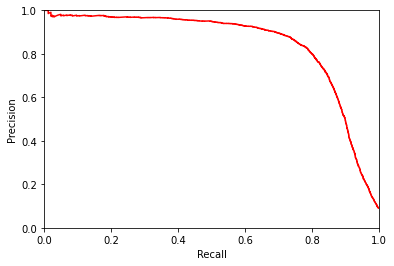

In [41]:
# It's also possible to plot precision directly against recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'r-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plot_precision_vs_recall(precisions, recalls)

In [27]:
# Depending on the project, we might want a specific precision value
# Let's say that we want the precision value of 90%.
# Now we can select a threshold value that will suit this.
# On the first plot, we can see that the precision of 90% is at about 30000 threshold value

y_train_pred_90 = (y_scores > 30000)

# now we can veirfy the precision and check the recall
p = precision_score(y_train_5, y_train_pred_90)
r = recall_score(y_train_5, y_train_pred_90)

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')


Precision: 100.0%
Recall: 0.22%


In [21]:
# Because of choosing the score of 30000, we got a high precision score
# however, the recall score is near 0, which means that out of all 5's
# only 0.2% got classified as 5's!

# There's a lower threshold score we can choose that's also around 90% recall value ~ 4500
y_train_pred_90 = (y_scores > 4500)

p = precision_score(y_train_5, y_train_pred_90)
r = recall_score(y_train_5, y_train_pred_90)

print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

# Whith this score, we can see that most of the 5's have been identified correctlty

Precision: 95.91%
Recall: 43.11%


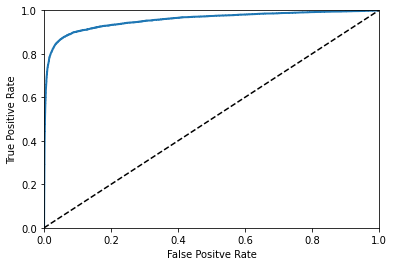

In [29]:
# We can also plot the ROC curve
# This shows us the change between the true and false positive rates.

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])

plot_roc(fpr, tpr)

In [30]:
# we can compare this way a number of models by calculating the Area Under the Curve (AUC)

auc = roc_auc_score(y_train_5, y_scores)
print(f'AUC: {auc}')

AUC: 0.956158528645071


In [32]:
# We can now train anothre model (random forrest classifier) and compare it to the outputs from the sgd one

forest_class = RandomForestClassifier(random_state=42)

# There's a slight difference in how rfc will determine it's choice.
# instead of using the threshold and decision fucntion value to determine what class the datapoint is in,
# rfc uses an array of size [number of datapoints * number of classes] which contains probability of
# a datapoint being assigned to each class

y_probas_forest = cross_val_predict(forest_class, X_train, y_train_5, cv=3, method='predict_proba')

# Now we have the probabilities of each class.
# But in order to calculate the the RAC or the PR curves, we need to calculate some sort of a score.
# Since this is a binary classifier, we can just use one of the probablity scores as our score

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [35]:
y_probas_forest[:, 1]


array([0.02, 0.  , 0.13, ..., 0.02, 0.01, 0.  ])

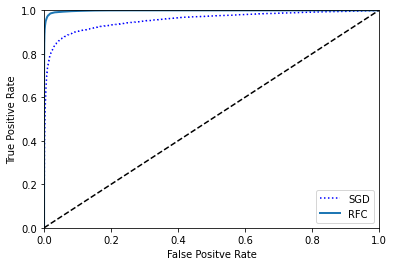

In [36]:
# Now we can plot and compare the two models

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc(fpr_forest, tpr_forest, 'RFC')
plt.legend(loc='lower right')
plt.show()

# We can see that the random forest model manages to classify the 5's a lot better than the SGD
# By the fact that is 'stcks' to the top left corener a lot more

In [37]:
# We can also measure the difference between the two by calculating the AUC score

auc_forest = roc_auc_score(y_train_5, y_scores_forest)
print(f'Random Forest AUC score: {auc_forest}\nSGD AUC score: {auc}')

Random Forest AUC score: 0.9985195015023628
SGD AUC score: 0.956158528645071


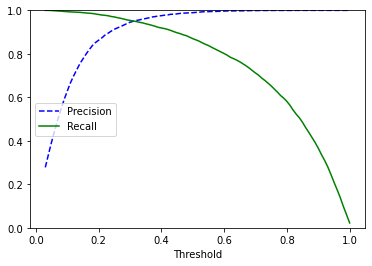

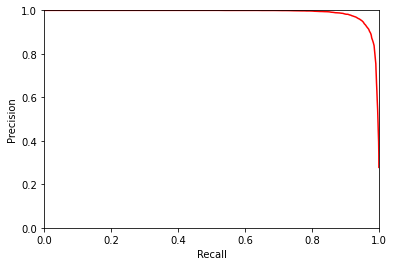

In [42]:
# Lastly, we can calculate Precision and Recall for this model as well

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)
plt.show()

plot_precision_vs_recall(precisions_forest, recalls_forest)

In [43]:
# Judging by the first plot, in order to get 90% recall, we'd need to set the threshold to about 0.4
y_train_pred_90_forest = (y_scores_forest > 0.4)

p_forest = precision_score(y_train_5, y_train_pred_90_forest)
r_forest = recall_score(y_train_5, y_train_pred_90_forest)

print(f'Precision: {round(p_forest*100,2)}%\nRecall: {round(r_forest*100,2)}%')

# This is a lot better than the SGD model

Precision: 97.78%
Recall: 91.61%
